In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
os.chdir("../../../../")

import yaml
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import mudata as md
import muon as mu
import numpy as np
import scanpy as sc
from matplotlib import gridspec
import scanpy.external as sce
from scipy import sparse

from utils.utils import *
from utils.plotting import *

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=100,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)
import matplotlib as mpl

sc.set_figure_params(dpi=100)
sns.set(style="white")

Global seed set to 0
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
data_path = "data/anca/exploratory/ANCA_28PK28PB_T.h5mu"
mudata = md.read_h5mu(data_path)

In [3]:
mudata

MuData object with n_obs × n_vars = 74435 × 50583
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'CD3_count', 'RNA_snn_res.0.6', 'patient', 'sample', 'case', 'tissue', 'nCount_ADT', 'nFeature_ADT', 'frac.mito', 'frac.ribo', 'nCount_CITE', 'nFeature_CITE', 'Feature_Count_ratio', 'RNA_snn_res.0.1', 'seurat_clusters', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'RNA_snn_res.0.05', 'RNA_snn_res.0.08', 'RNA_snn_res.0.15', 'RNA_snn_res.0.01', 'RNA_snn_res.0.02', 'RNA_snn_res.0.03', 'cell_type', 'meta_cell_type', 'RNA_snn_res.0.5', 'RNA_snn_res.0.7', 'RNA_snn_res.0.8', 'cell_type_yu'
  obsm:	'X_harmony', 'X_pca', 'X_umap'
  4 modalities
    RNA:	74435 x 50352
      layers:	'counts'
    ADT:	74435 x 17
      layers:	'counts'
    CITE:	74435 x 210
      layers:	'counts'
    HTO:	74435 x 4
      layers:	'counts'

In [3]:
[var for var in mudata.mod["CITE"].var_names

Index(['PDL1', 'CD154', 'CD3', 'CD4', 'CD8', 'CD56', 'CD45', 'CD19', 'CD14',
       'HLAABC',
       ...
       'CD82', 'BB27', 'IL21R', 'C5aR', 'Podocalyxin', 'CD224', 'LIGHT',
       'TRAMP', 'Hash1', 'Hash2'],
      dtype='object', length=210)

In [8]:
adt = mudata.mod["ADT"]
adt.obs = mudata.obs.copy()
mask = adt.X.sum(axis=1) > 0
mask = np.array(mask)[:, 0]
adt[mask, :].obs.patient.value_counts().shape[0]

1

In [13]:
adt = adt[adt.obs.patient == "P019", :]
np.array(adt.X.sum(axis=1)).min()

29.15527211864221

In [25]:
adt = mudata.mod["CITE"]
adt.obs = mudata.obs.copy()
mask = adt.X.sum(axis=1) > 0
mask = np.array(mask)[:, 0]
adt[mask, :].obs.patient.value_counts().shape[0]

18

... storing 'cell_type' as categorical
... storing 'meta_cell_type' as categorical


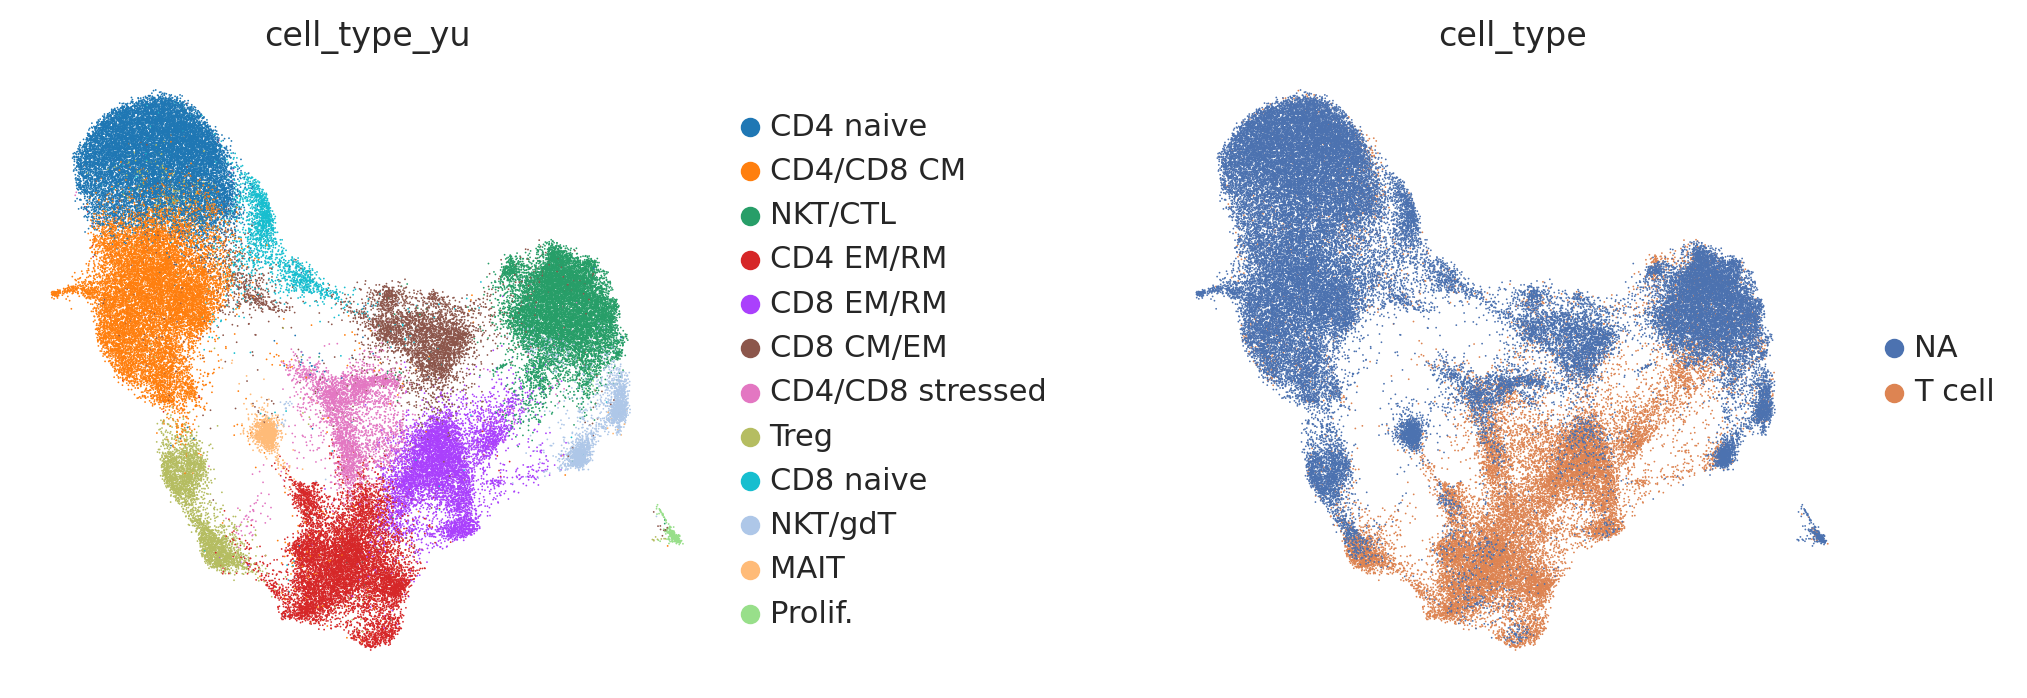

In [156]:
mod_rna = mudata.mod["RNA"]
mod_rna.obsm["X_umap"] = mudata.obsm["X_umap"]
mod_rna.obs["cell_type"] = mudata.obs["cell_type"]
mod_rna.obs["meta_cell_type"] = mudata.obs["meta_cell_type"]
mod_rna.obs["cell_type_yu"] = mudata.obs["cell_type_yu"]
sc.pl.umap(mod_rna, color=["cell_type_yu", "cell_type"], frameon=False, wspace=0.5)

## Subset data

In [26]:
mudata.obs["patient"].value_counts()

P139    13536
P108     6990
P028     5996
P008     5942
P126     4016
P129     2898
P019     2849
P089     2715
P015     2584
P067     2583
P070     2577
P007     2120
P005     2029
P055     2009
P088     1990
P137     1937
P053     1916
P120     1909
P029     1522
P018     1272
P059     1017
P115      990
P060      789
P023      721
P100      600
P025      461
P103      425
P118       42
Name: patient, dtype: int64

In [5]:
patient_to_remove = "P120"
mudata = mudata[mudata.obs["patient"] != patient_to_remove, :].copy()

In [13]:
adt = mudata.mod["CITE"]
adt.obs = mudata.obs.copy()
mask = adt.X.sum(axis=1) > 0
mask = np.array(mask)[:, 0]
cite_patients = adt[mask, :].obs.patient.value_counts().index.tolist()
adt[mask, :].obs[["patient"]].groupby("patient").value_counts().shape[0]

17

In [8]:
cite_patients

['P139',
 'P108',
 'P126',
 'P129',
 'P089',
 'P067',
 'P070',
 'P055',
 'P088',
 'P137',
 'P053',
 'P059',
 'P115',
 'P060',
 'P100',
 'P103',
 'P118']

In [14]:
adt = mudata.mod["ADT"]
adt.obs = mudata.obs.copy()
mask = adt.X.sum(axis=1) > 0
mask = np.array(mask)[:, 0]
adt_patients = adt[mask, :].obs.patient.value_counts().index.tolist()
adt[mask, :].obs[["patient"]].groupby("patient").value_counts().shape[0]

1

In [16]:
len(adt.var_names)

17

In [42]:
set(cite_patients).intersection(set(adt_patients))

set()

In [38]:
adt = mudata.mod["CITE"]
adt.obs = mudata.obs.copy()
mask = adt.X.sum(axis=1) == 0
mask = np.array(mask)[:, 0]
adt[mask, :].obs.patient.value_counts().shape[0]
adt[mask, :].obs.groupby("patient")["tissue"].value_counts().shape[0]

20

## Preprocessing and QC

In [159]:
relevant_obs = ["patient", "sample", "tissue", "cell_type_yu"]
mudata.obs = mudata.obs[relevant_obs].copy()

### Preprocessing RNA

In [160]:
mod_rna = mudata.mod["RNA"]
mod_rna

AnnData object with n_obs × n_vars = 72526 × 50352
    obs: 'cell_type', 'meta_cell_type', 'cell_type_yu'
    uns: 'cell_type_yu_colors', 'cell_type_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [161]:
mod_rna = ad.AnnData(
    mod_rna.layers["counts"].copy(),
    obs=mudata.obs.copy(),
    # obsm=anca_data.obsm.copy(),
    var=mod_rna.var[[]],
    layers={"counts": mod_rna.layers["counts"].copy()},
)

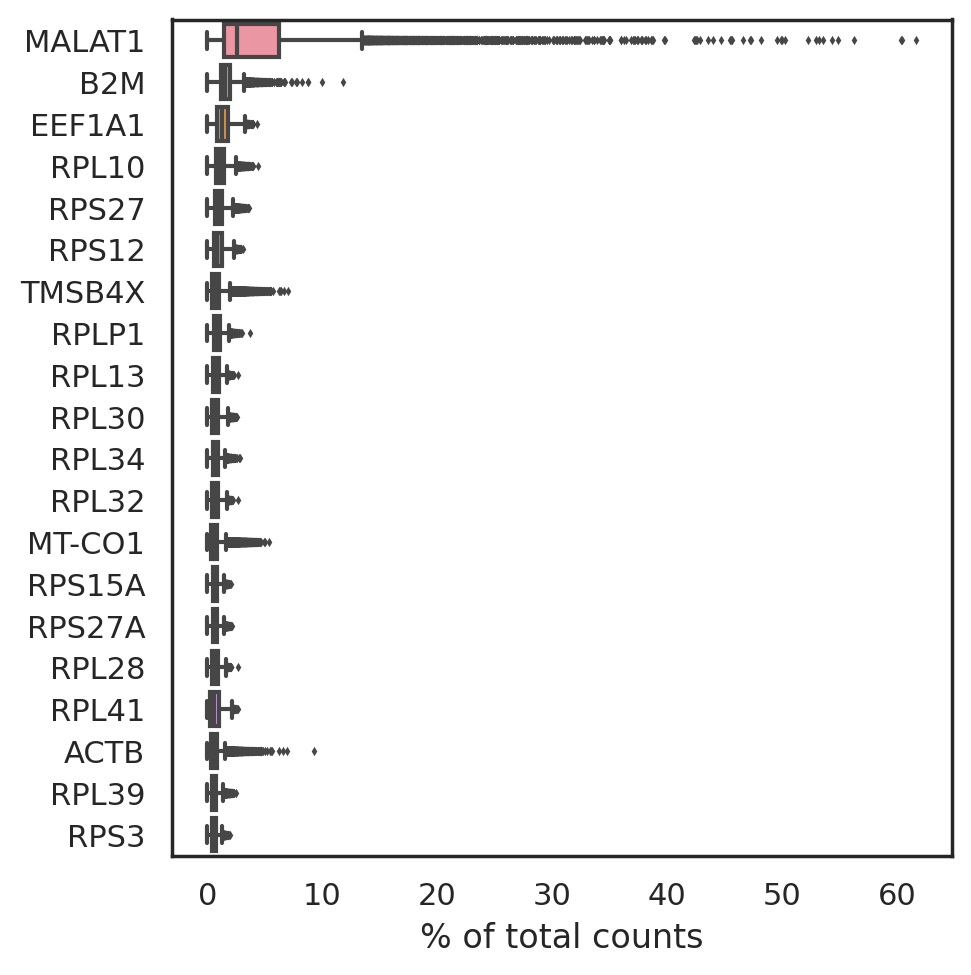

In [162]:
sc.pl.highest_expr_genes(
    mod_rna,
    n_top=20,
)

In [163]:
sc.pp.filter_cells(mod_rna, min_genes=200)
sc.pp.filter_genes(mod_rna, min_cells=10)

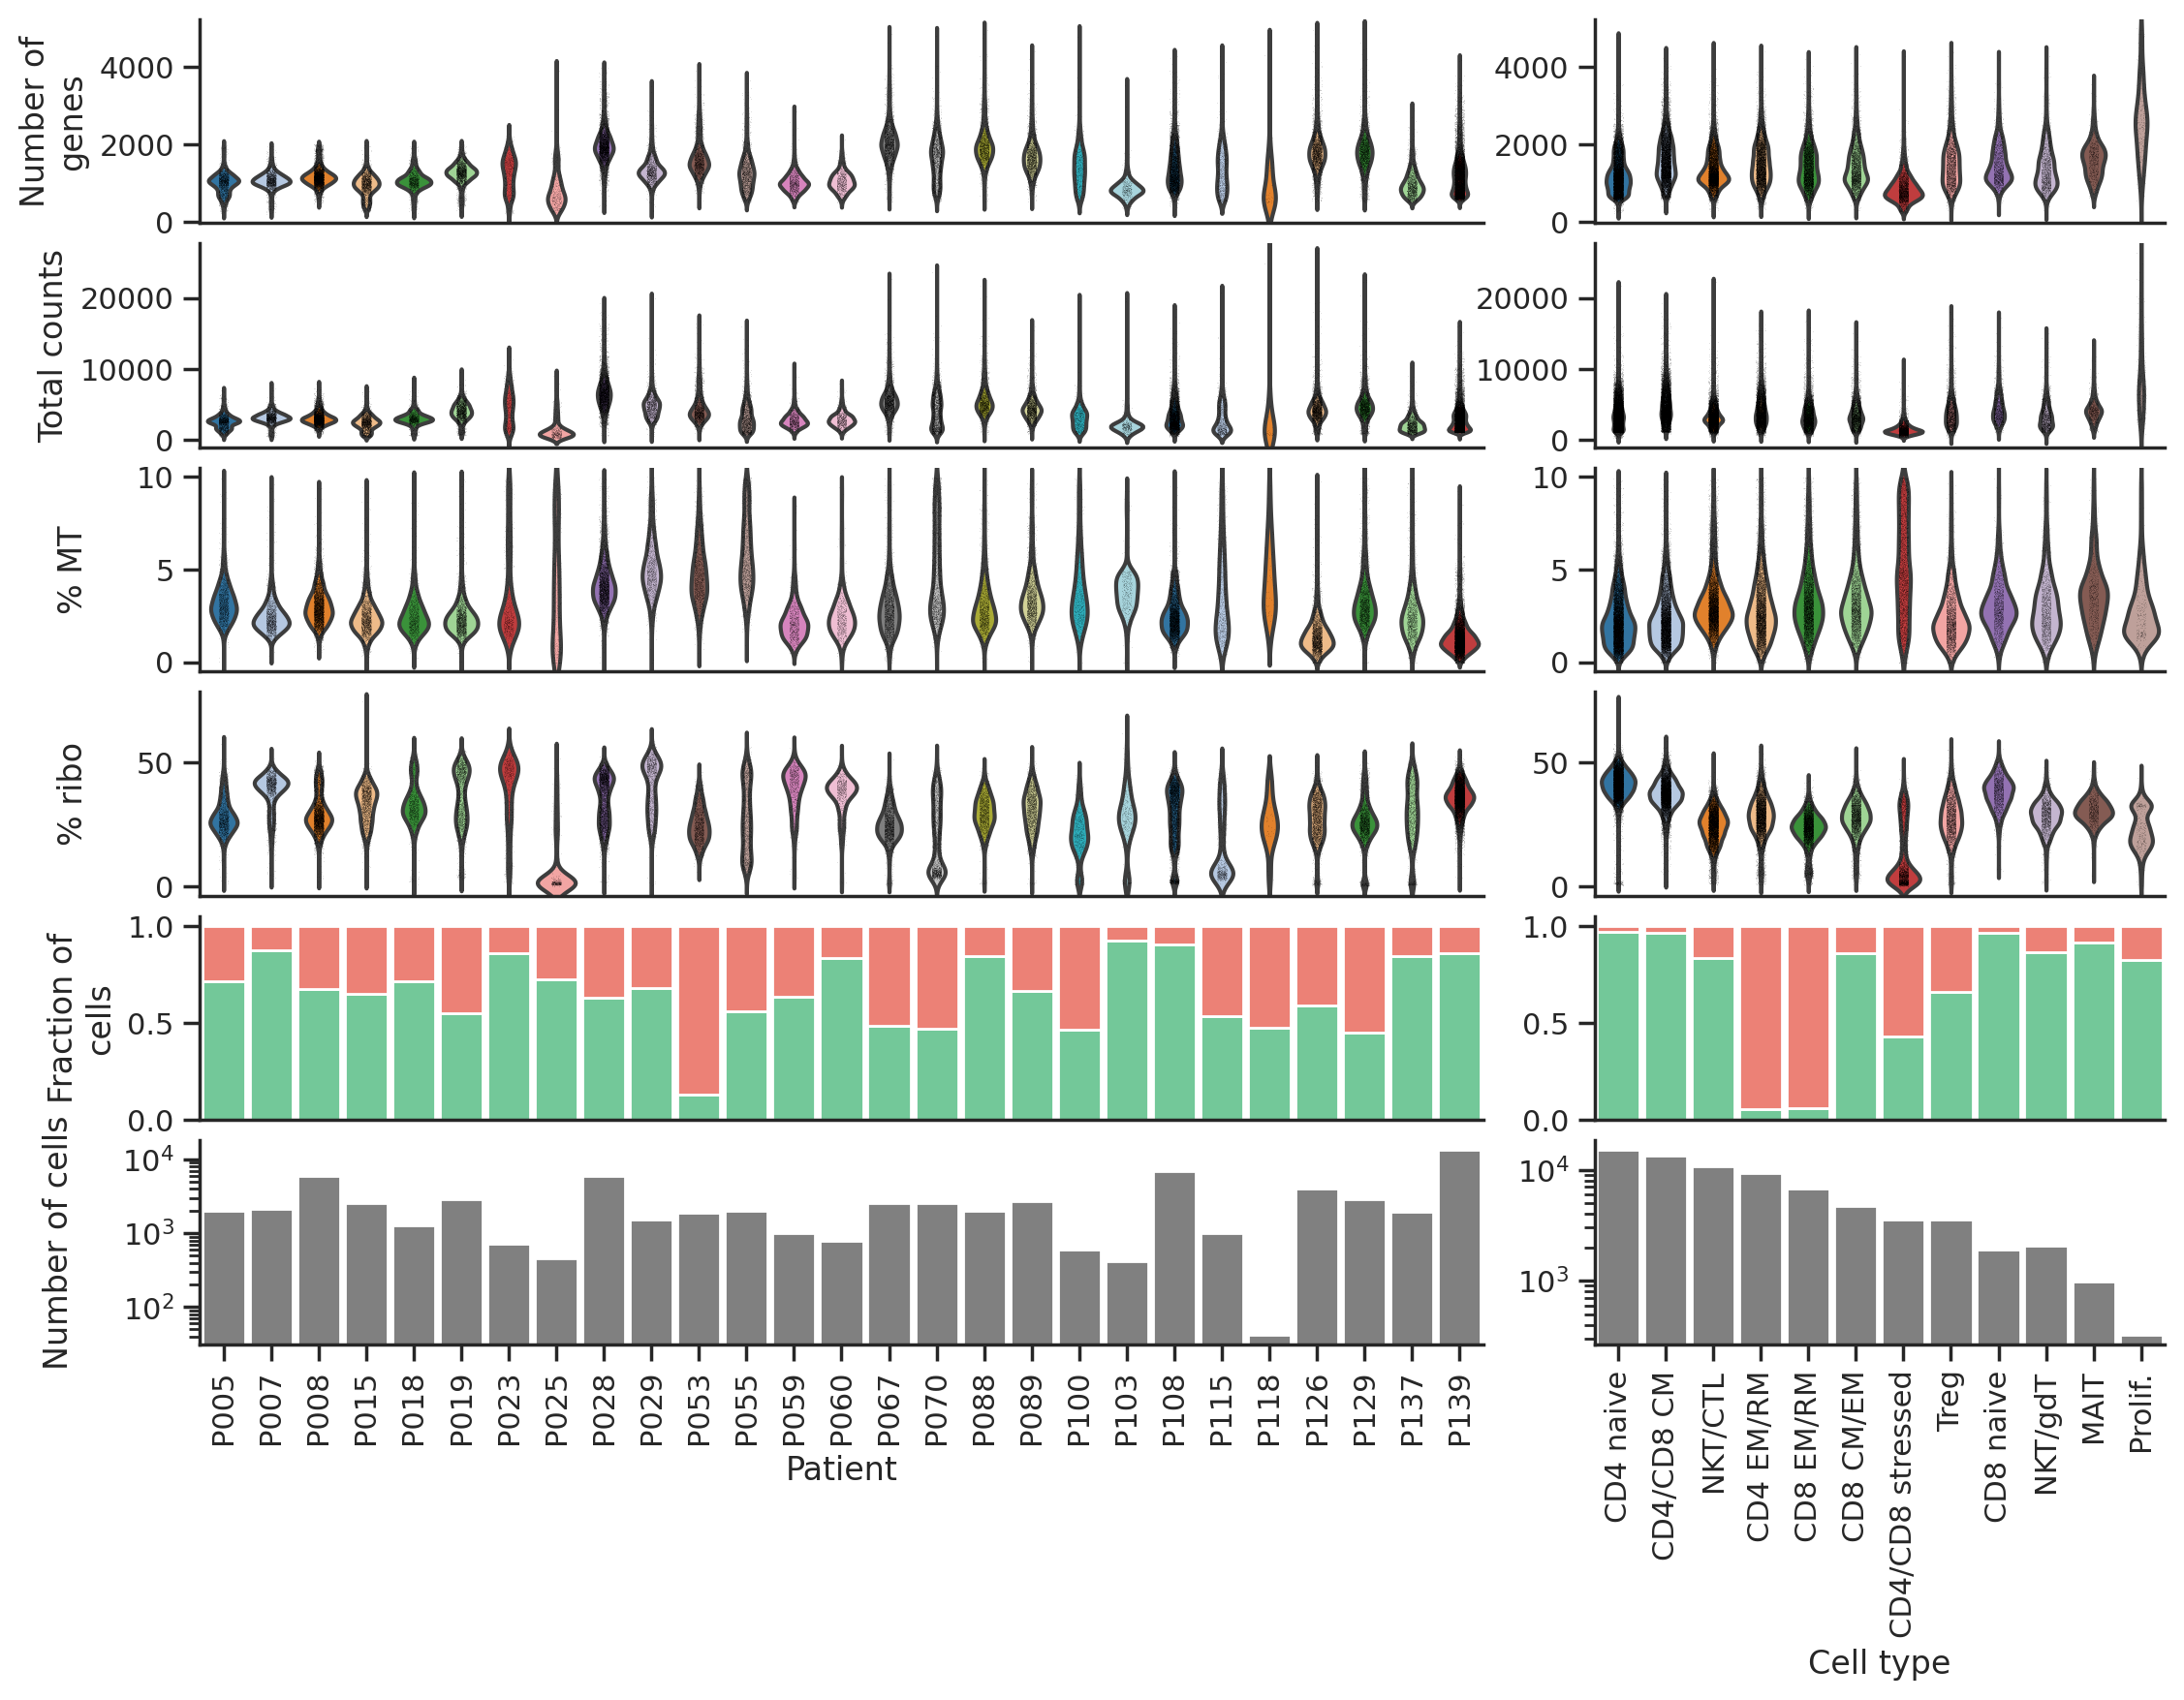

In [164]:
plot_qc(mod_rna, cell_type_key="cell_type_yu")

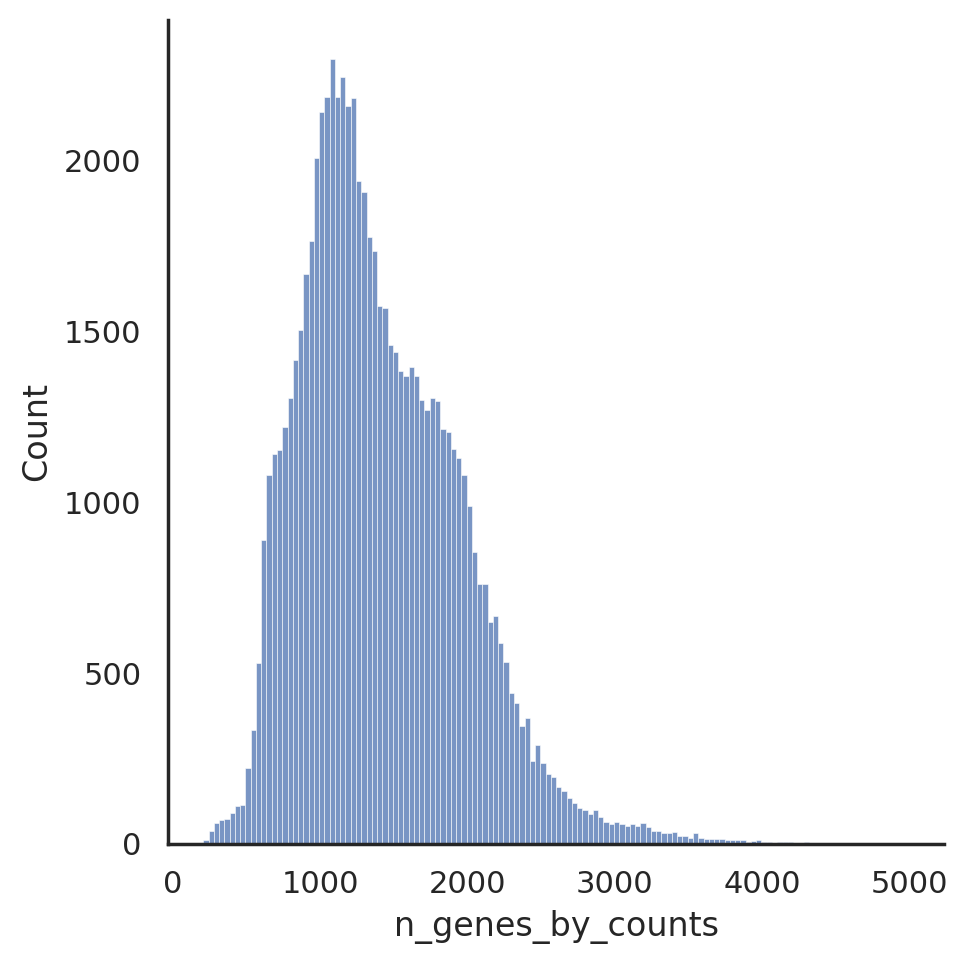

In [165]:
sns.displot(mod_rna.obs.n_genes_by_counts)

In [166]:
mod_rna.obs.n_genes_by_counts.min(), mod_rna.obs.total_counts.min()

(205, 294.0)

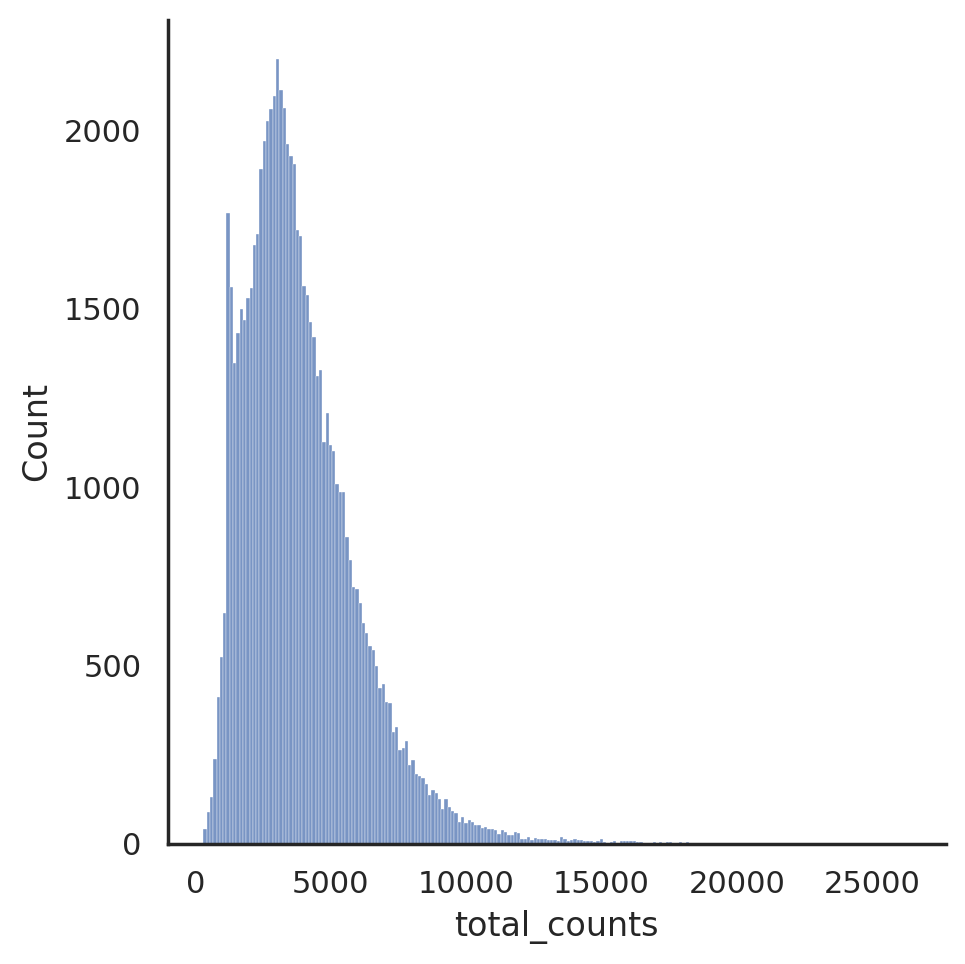

In [167]:
sns.displot(mod_rna.obs.total_counts)

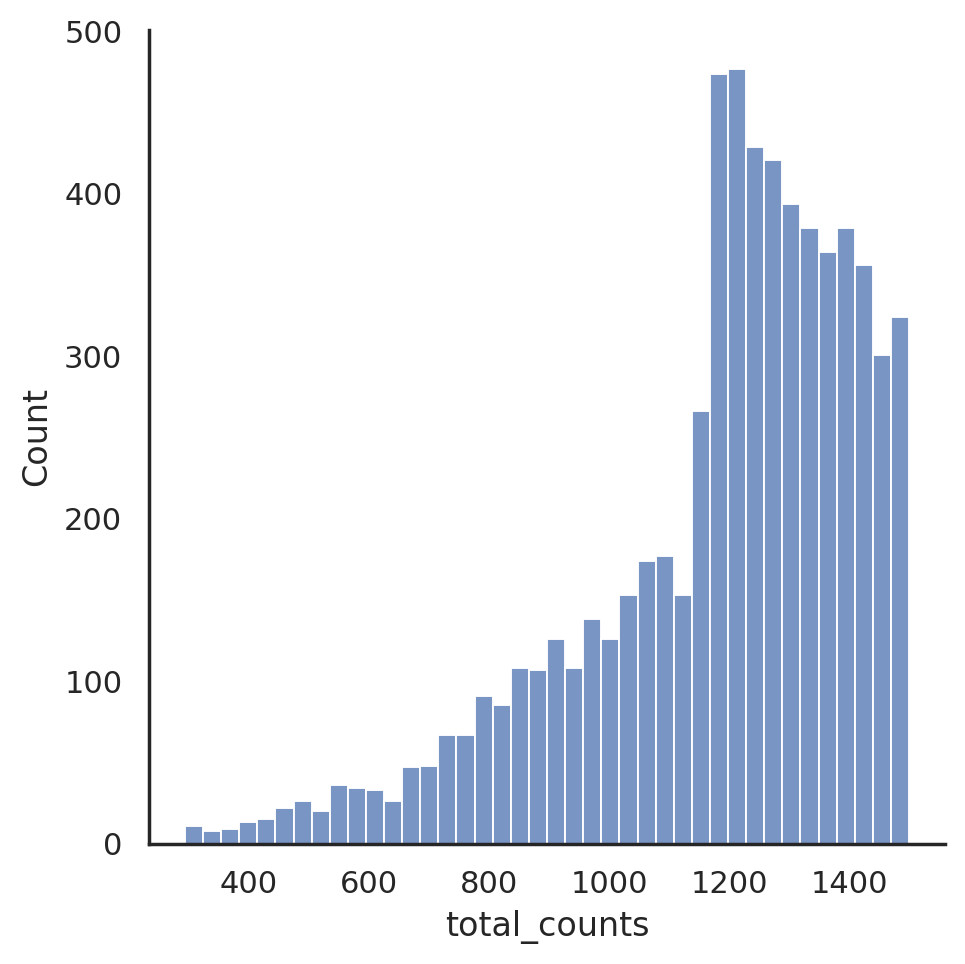

In [168]:
sns.displot(mod_rna[mod_rna.obs.total_counts < 1500].obs.total_counts)

In [169]:
# get patient in order of numbers
patient_order = mod_rna.obs.groupby("patient").size().sort_values().index
patient_order

Index(['P118', 'P103', 'P025', 'P100', 'P023', 'P060', 'P115', 'P059', 'P018',
       'P029', 'P053', 'P137', 'P088', 'P055', 'P005', 'P007', 'P070', 'P067',
       'P015', 'P089', 'P019', 'P129', 'P126', 'P008', 'P028', 'P108', 'P139'],
      dtype='object', name='patient')

<AxesSubplot: xlabel='patient', ylabel='total_counts'>

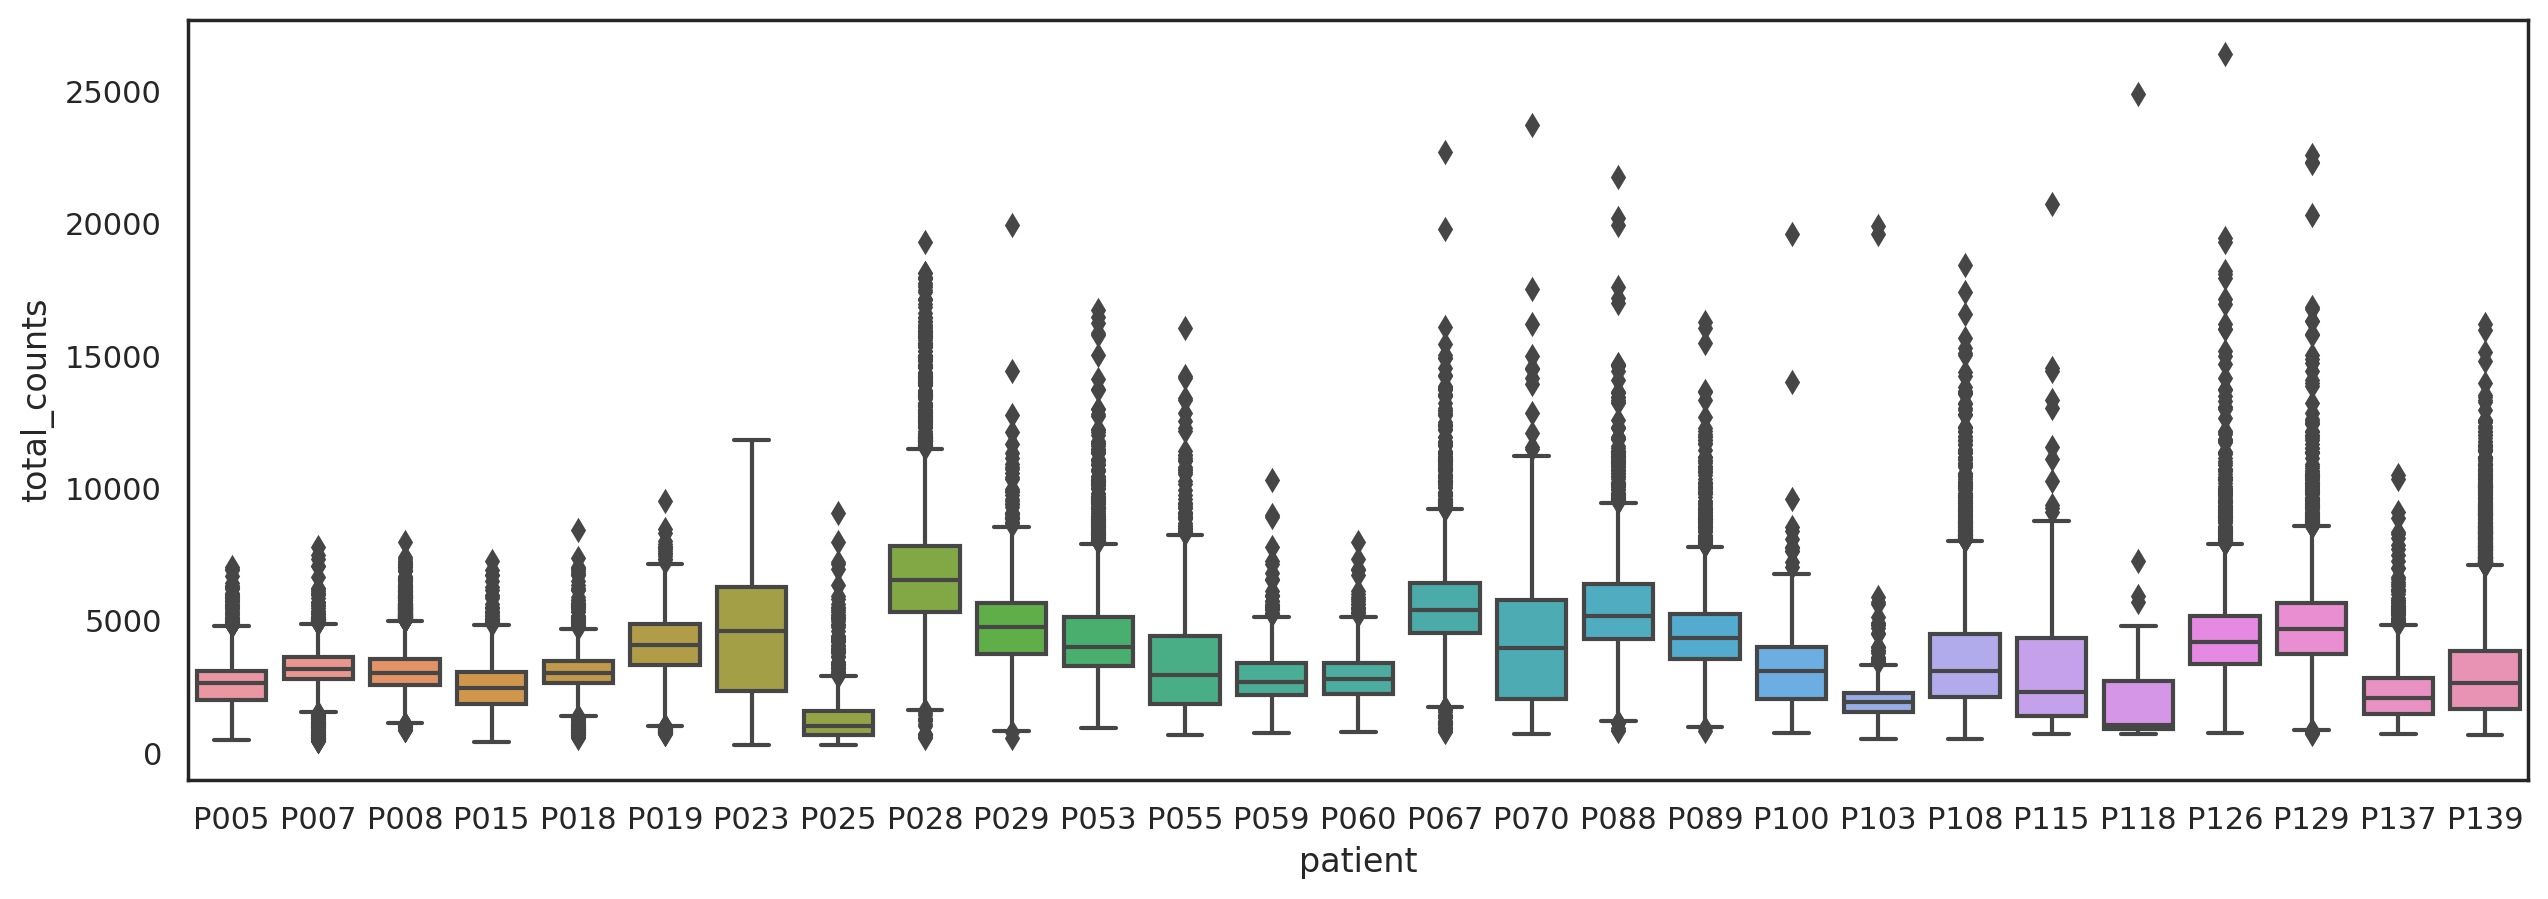

In [170]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(y=mod_rna.obs.total_counts, x=mod_rna.obs["patient"], ax=ax)

<AxesSubplot: xlabel='patient', ylabel='n_genes_by_counts'>

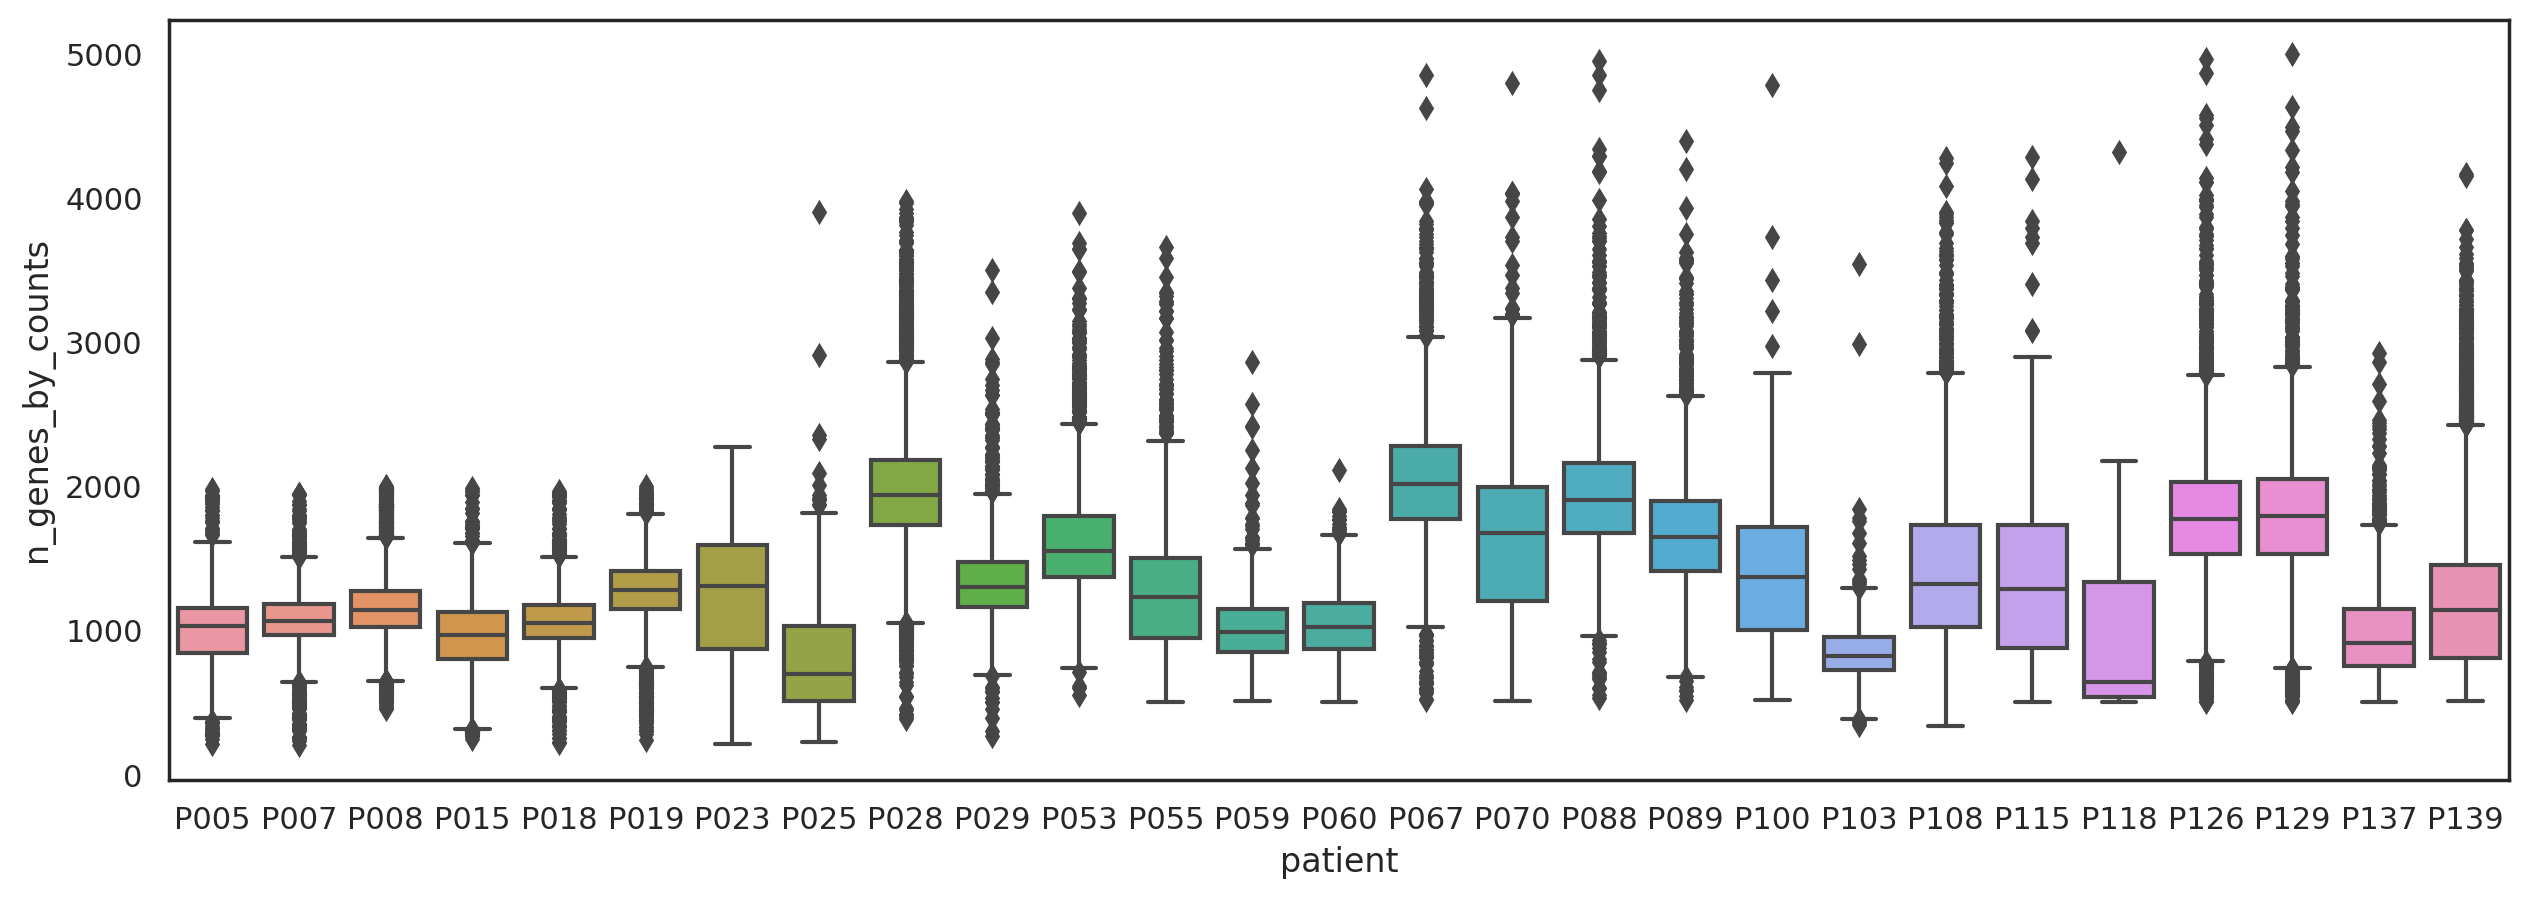

In [171]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(y=mod_rna.obs.n_genes_by_counts, x=mod_rna.obs["patient"], ax=ax)

... storing 'patient' as categorical
... storing 'sample' as categorical
... storing 'tissue' as categorical


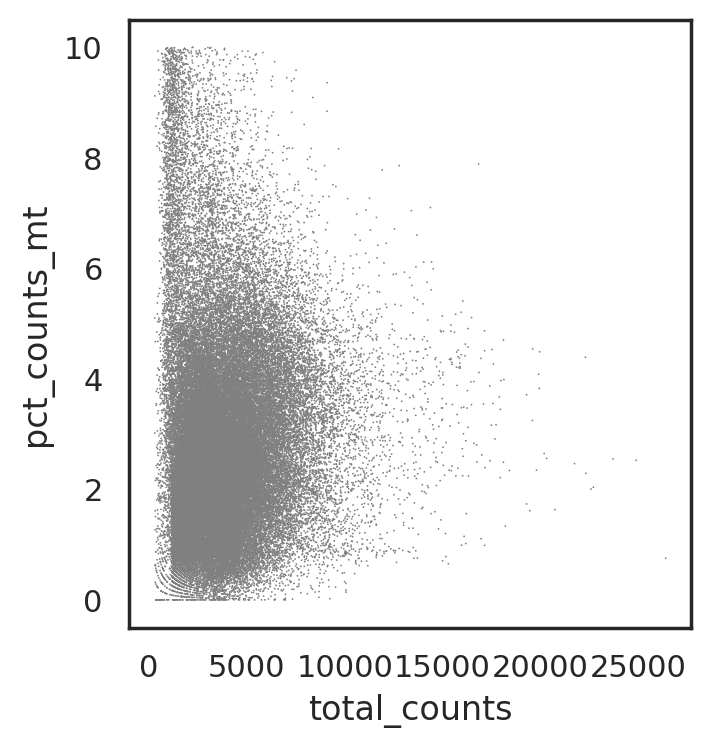

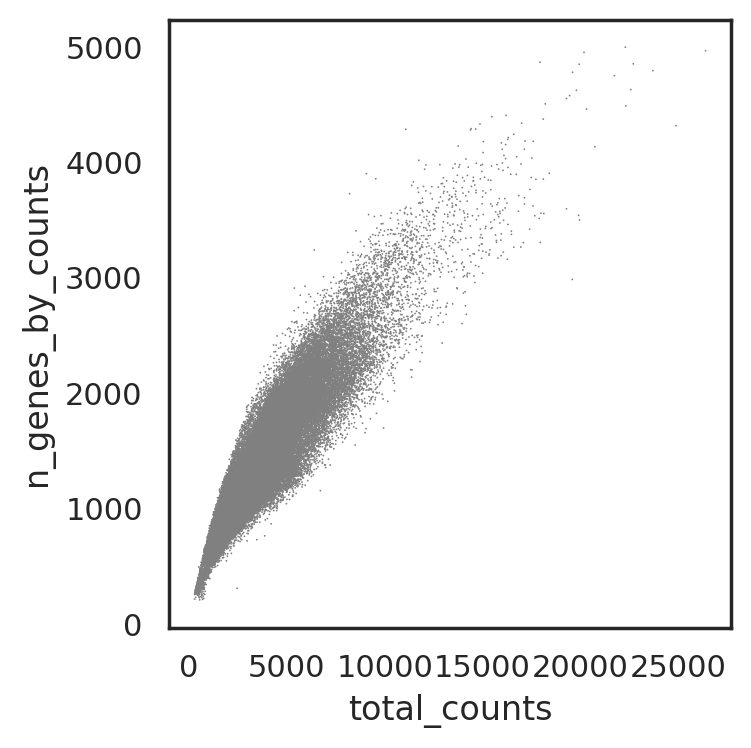

In [172]:
sc.pl.scatter(mod_rna, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(mod_rna, x="total_counts", y="n_genes_by_counts")

In [173]:
# total_counts_valley = 1400
# sum(mod_rna.obs.total_counts < total_counts_valley)
# mod_rna.obs[mod_rna.obs.total_counts < total_counts_valley].patient.value_counts()
# mod_rna = mod_rna[mod_rna.obs.total_counts > total_counts_valley, :].copy()

In [174]:
# get top x percent of cells
x = 1e-3
total_counts_max_mask = mod_rna.obs.total_counts > mod_rna.obs.total_counts.quantile(
    1 - x
)
total_counts_max_mask.sum()
# (mod_rna.obs.total_counts > 16000).sum()

73

In [175]:
mod_rna = mod_rna[
    mod_rna.obs.total_counts < mod_rna.obs.total_counts.quantile(1 - x), :
].copy()
sc.pp.filter_genes(mod_rna, min_cells=10)
mod_rna.shape

(72453, 21419)

In [176]:
log_normalize(mod_rna)

In [177]:
get_adata_stats(mod_rna)

min cells per sample: 19,
max cells per sample: 11615,
min n expressed genes per cell: 205,
max n expressed genes per cell: 4393,
min n cells expressing gene: 10



In [178]:
"IL12A" in mod_rna.var_names

True

In [179]:
mod_rna.layers["counts"].max()

3013.0

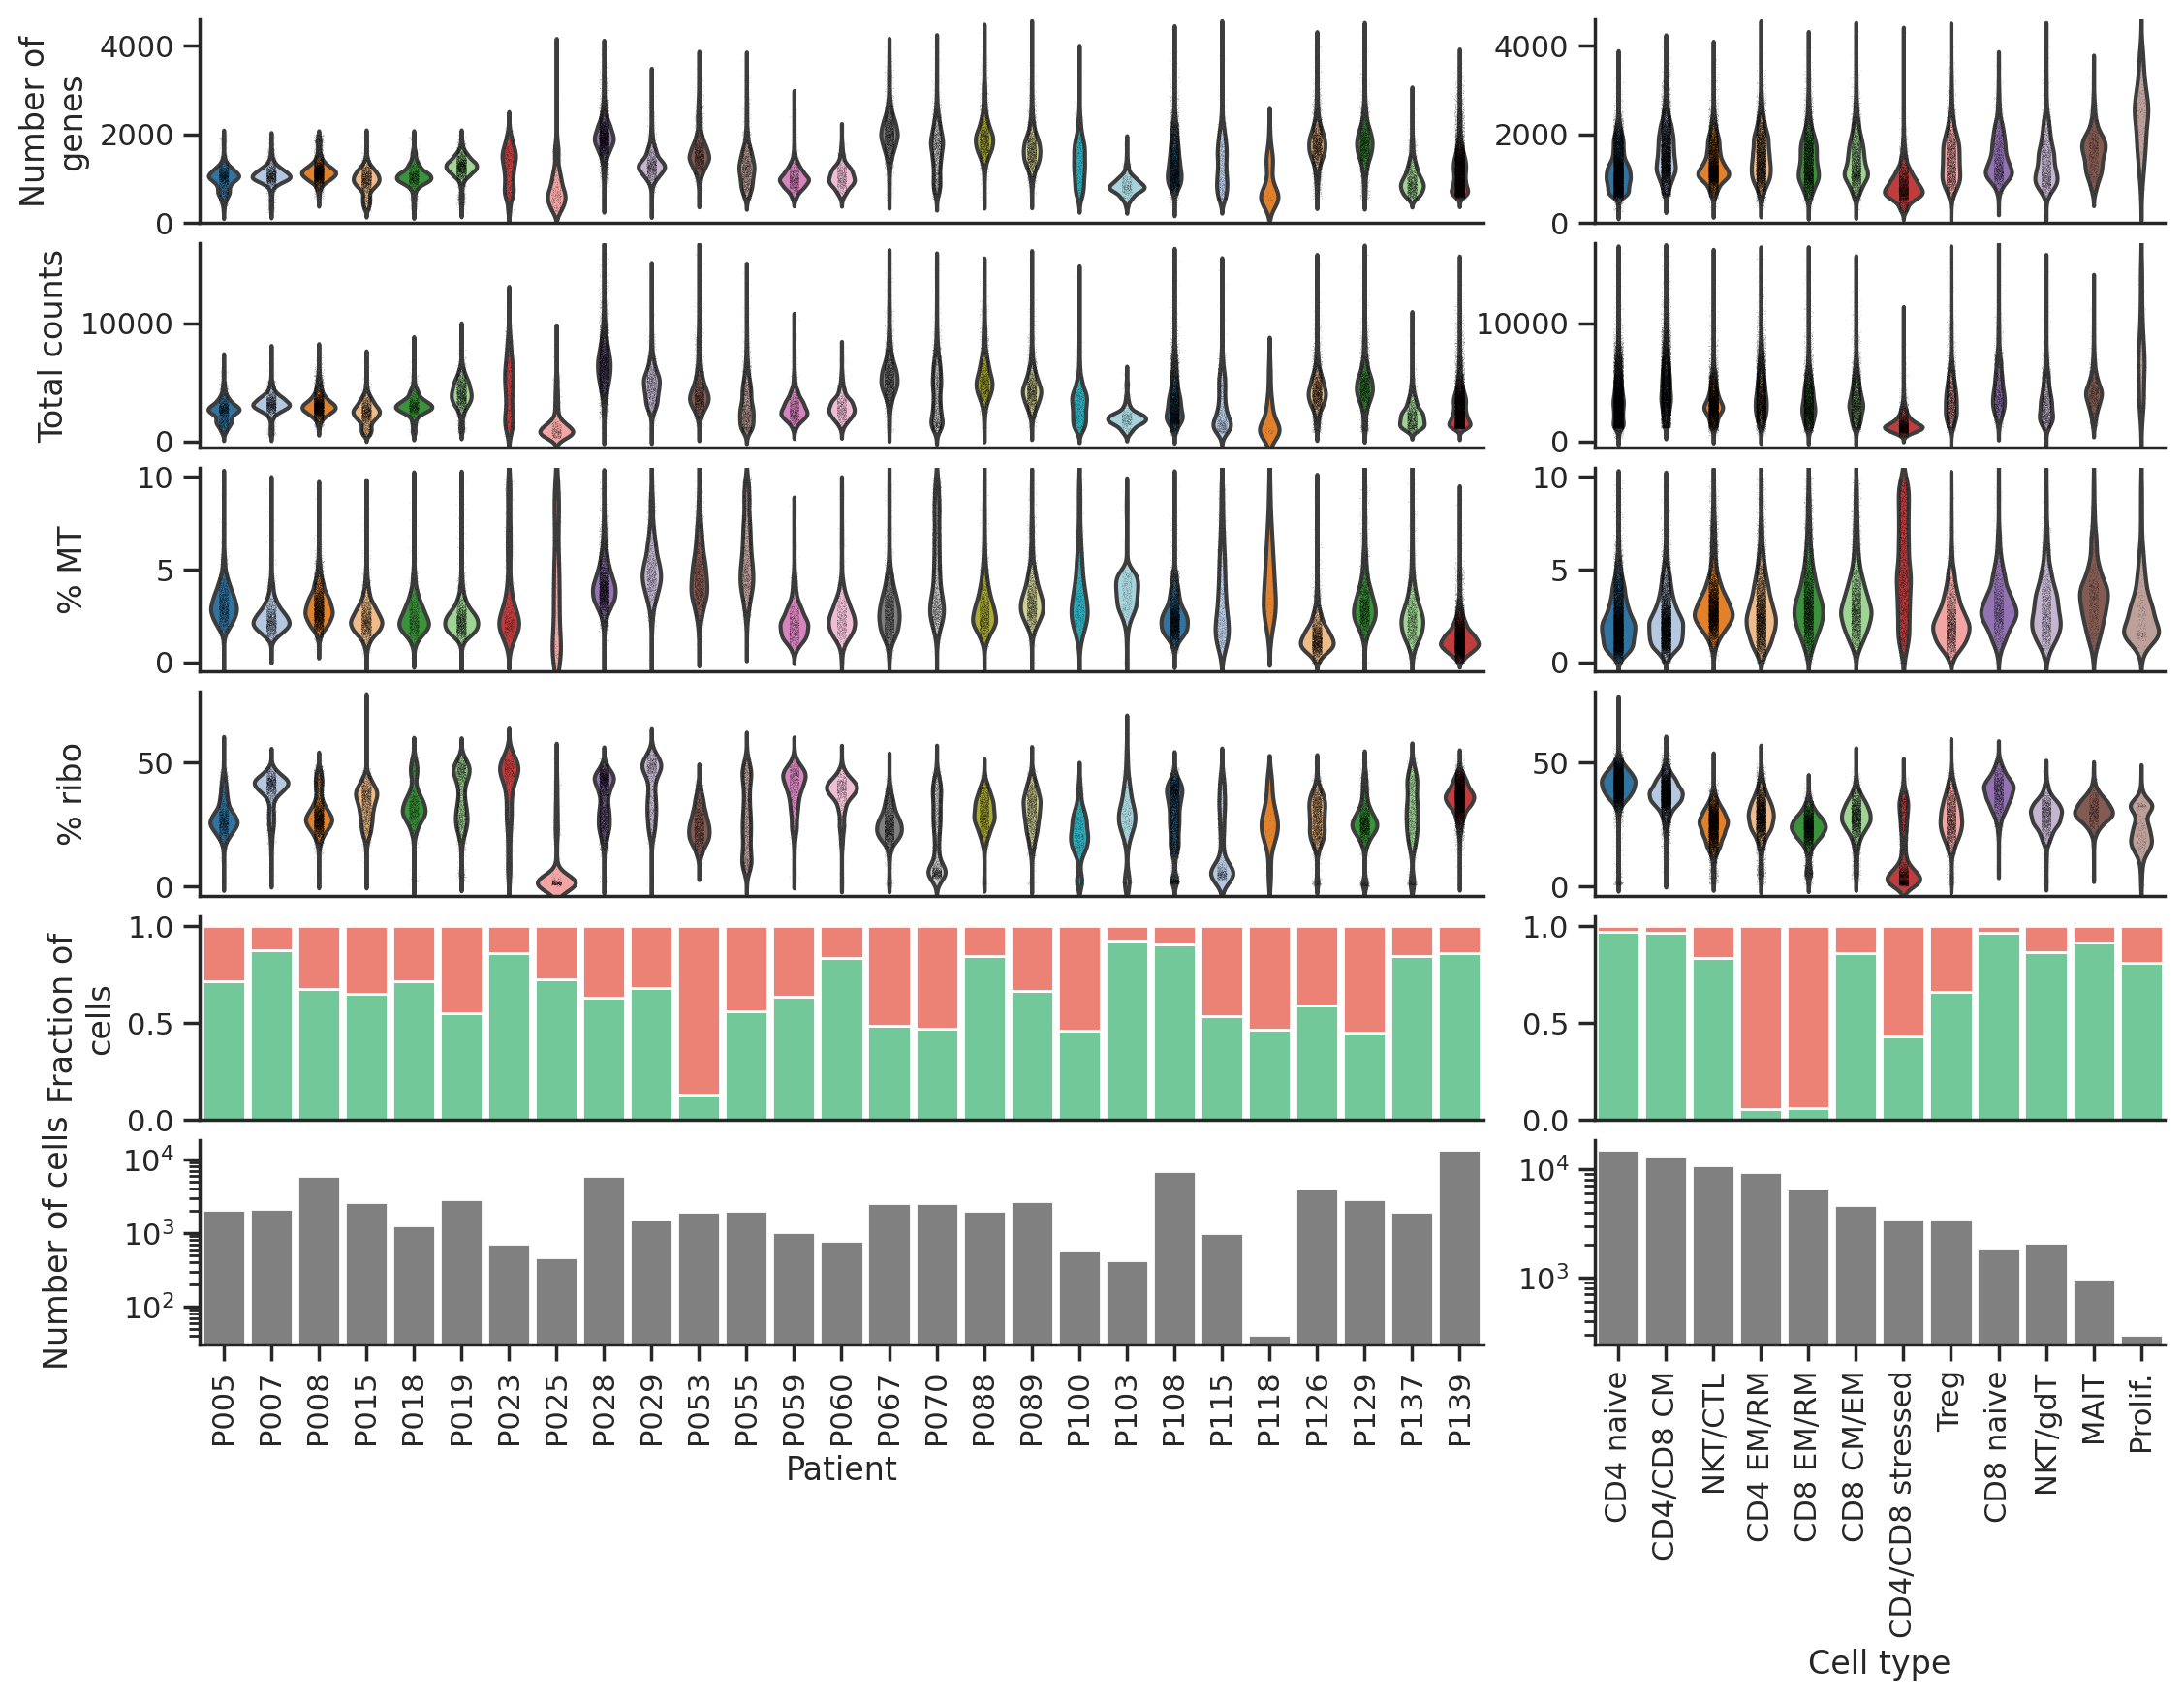

In [180]:
plot_qc(mod_rna, cell_type_key="cell_type_yu")

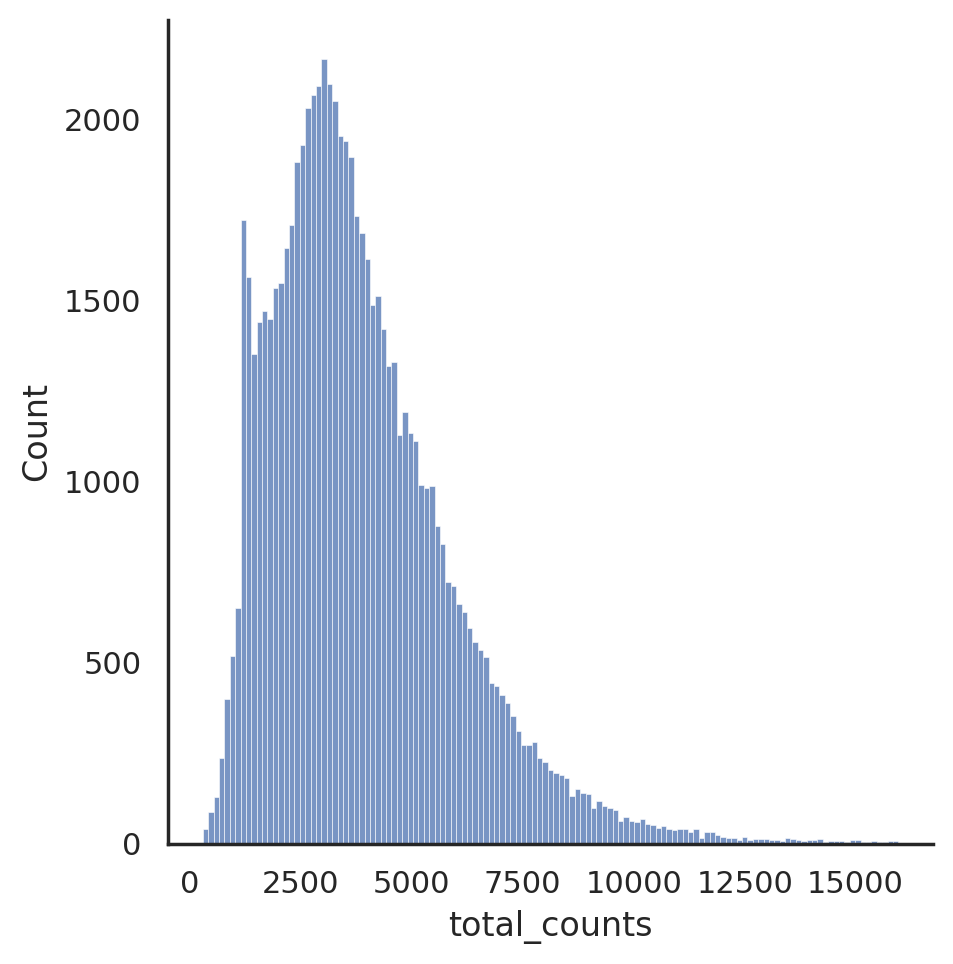

In [181]:
sns.displot(mod_rna.obs.total_counts)

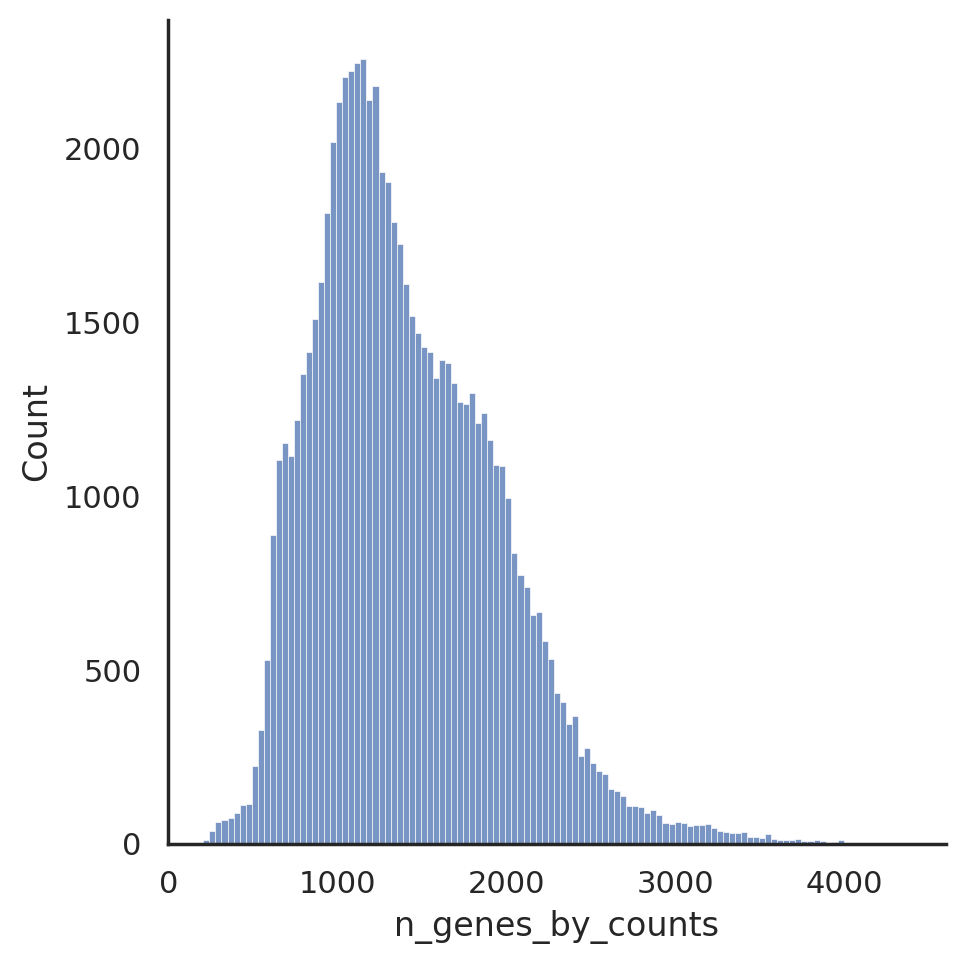

In [182]:
sns.displot(mod_rna.obs.n_genes_by_counts)

In [183]:
mod_rna

AnnData object with n_obs × n_vars = 72453 × 21419
    obs: 'patient', 'sample', 'tissue', 'cell_type_yu', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts', 'log1p'

### Preprocessing CITE

In [184]:
mod_cite = mudata.mod["CITE"]
mod_cite = mod_cite[mod_rna.obs_names, :].copy()
mod_cite

AnnData object with n_obs × n_vars = 72453 × 210
    layers: 'counts'

In [185]:
mod_cite = ad.AnnData(
    mod_cite.layers["counts"].copy(),
    obs=mudata.obs.loc[mod_cite.obs_names, :].copy(),
    # obsm=anca_data.obsm.copy(),
    var=mod_cite.var[[]],
    layers={"counts": mod_cite.layers["counts"].copy()},
)

In [186]:
mod_cite.var_names

Index(['PDL1', 'CD154', 'CD3', 'CD4', 'CD8', 'CD56', 'CD45', 'CD19', 'CD14',
       'HLAABC',
       ...
       'CD82', 'BB27', 'IL21R', 'C5aR', 'Podocalyxin', 'CD224', 'LIGHT',
       'TRAMP', 'Hash1', 'Hash2'],
      dtype='object', length=210)

In [187]:
var_names = [name for name in mod_cite.var_names if not "Hash" in name]
mod_cite = mod_cite[:, var_names].copy()

In [188]:
mod_cite.var_names

Index(['PDL1', 'CD154', 'CD3', 'CD4', 'CD8', 'CD56', 'CD45', 'CD19', 'CD14',
       'HLAABC',
       ...
       'GPR56', 'HLA.E', 'CD82', 'BB27', 'IL21R', 'C5aR', 'Podocalyxin',
       'CD224', 'LIGHT', 'TRAMP'],
      dtype='object', length=206)

In [189]:
get_adata_stats(mod_cite)

min cells per sample: 19,
max cells per sample: 11615,
min n expressed genes per cell: 0,
max n expressed genes per cell: 202,
min n cells expressing gene: 106



In [190]:
sc.pp.calculate_qc_metrics(mod_cite, inplace=True, percent_top=None)

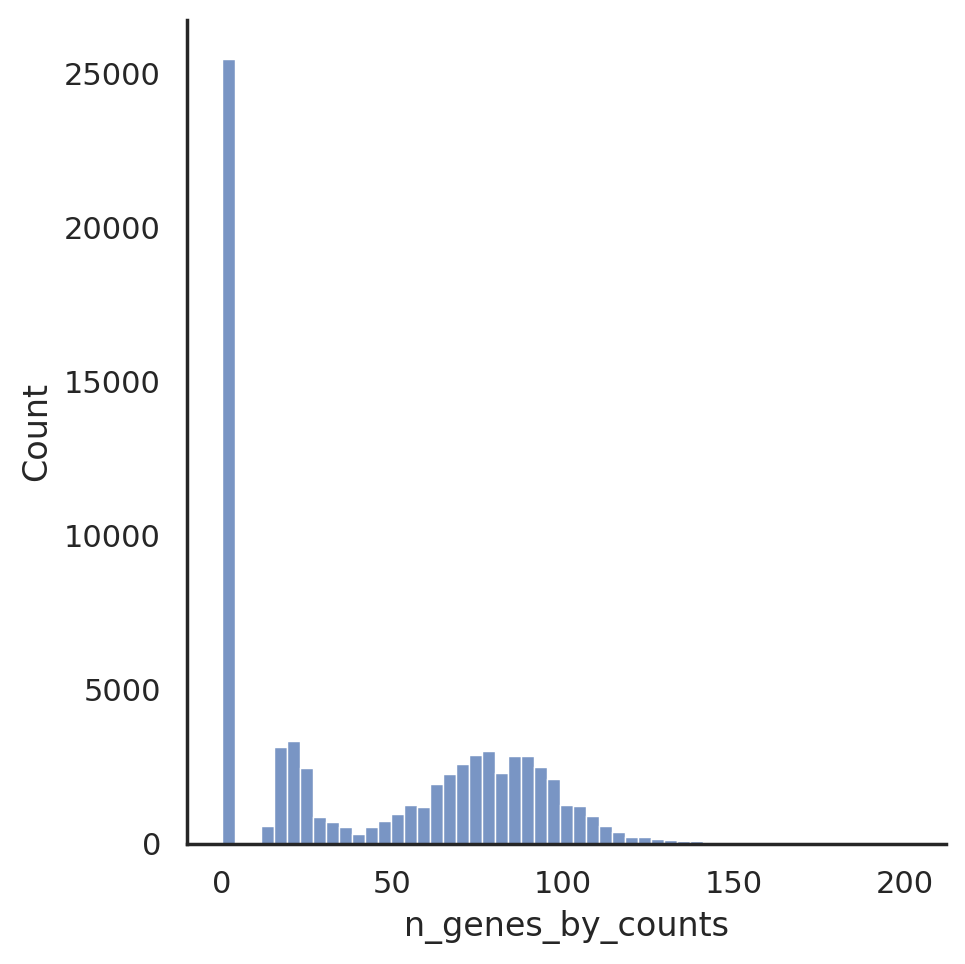

In [191]:
sns.displot(mod_cite.obs.n_genes_by_counts)

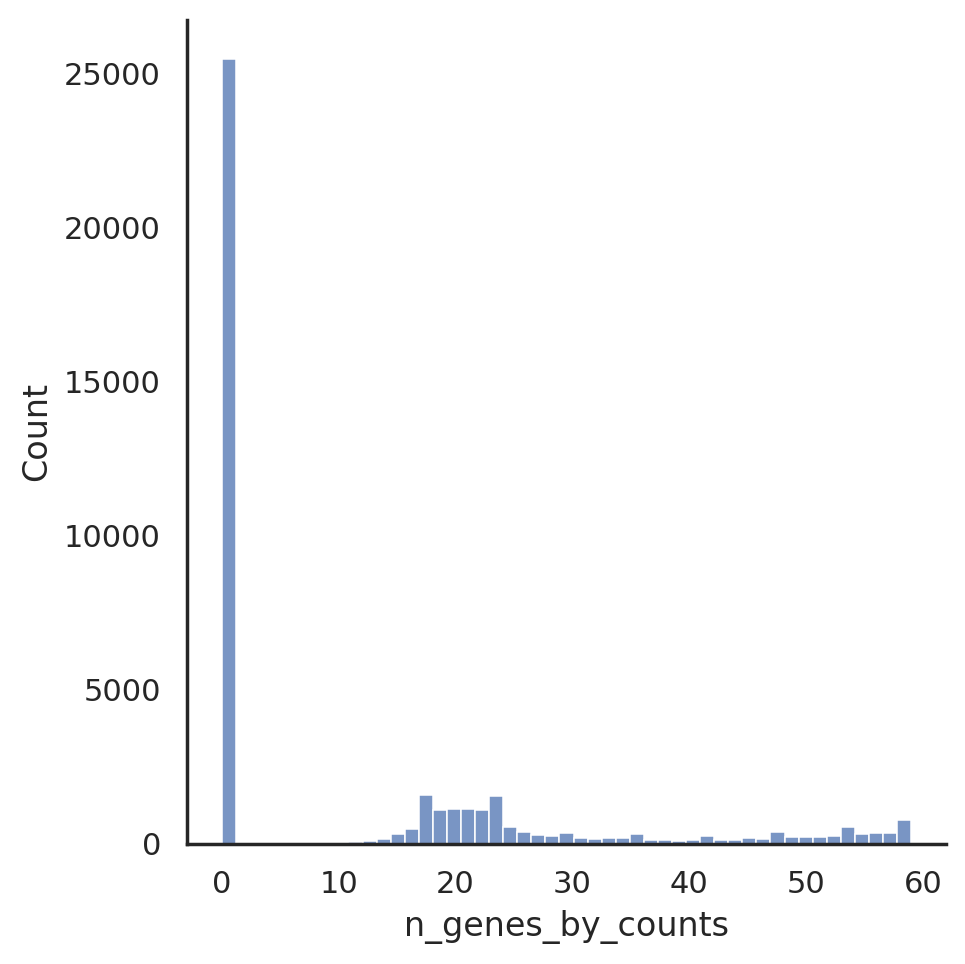

In [192]:
sns.displot(mod_cite[mod_cite.obs.n_genes_by_counts < 60].obs.n_genes_by_counts)

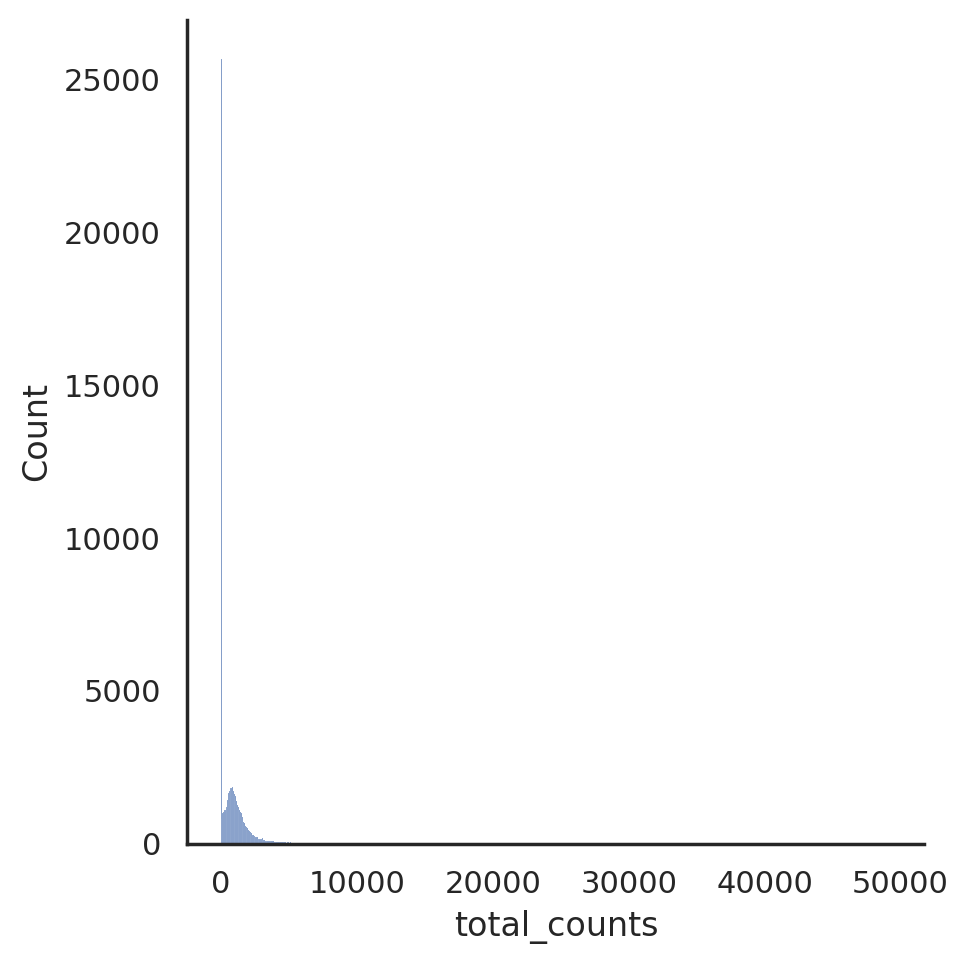

In [193]:
sns.displot(mod_cite.obs.total_counts)

In [194]:
# number of cells with total counts > 20000
sum(mod_cite.obs.total_counts > 15000)

25

In [195]:
# get 0.1% of cells with highest total counts
x = 5e-4
total_counts_max_cutoff = mod_cite.obs.total_counts.quantile(1 - x)
total_counts_max_mask = mod_cite.obs.total_counts < total_counts_max_cutoff
print(total_counts_max_mask.sum())
print(total_counts_max_cutoff)

72416
12179.796000000264


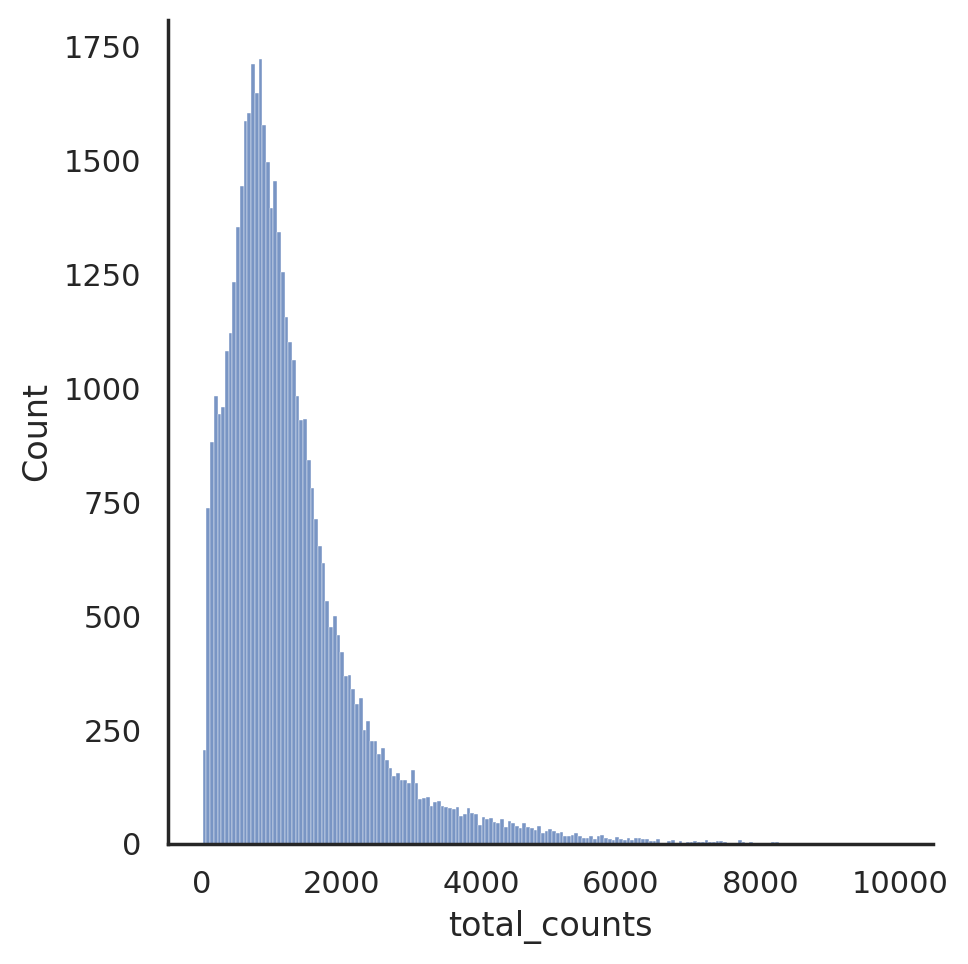

In [196]:
sns.displot(mod_cite.obs.query("total_counts>0 and total_counts<10000").total_counts)

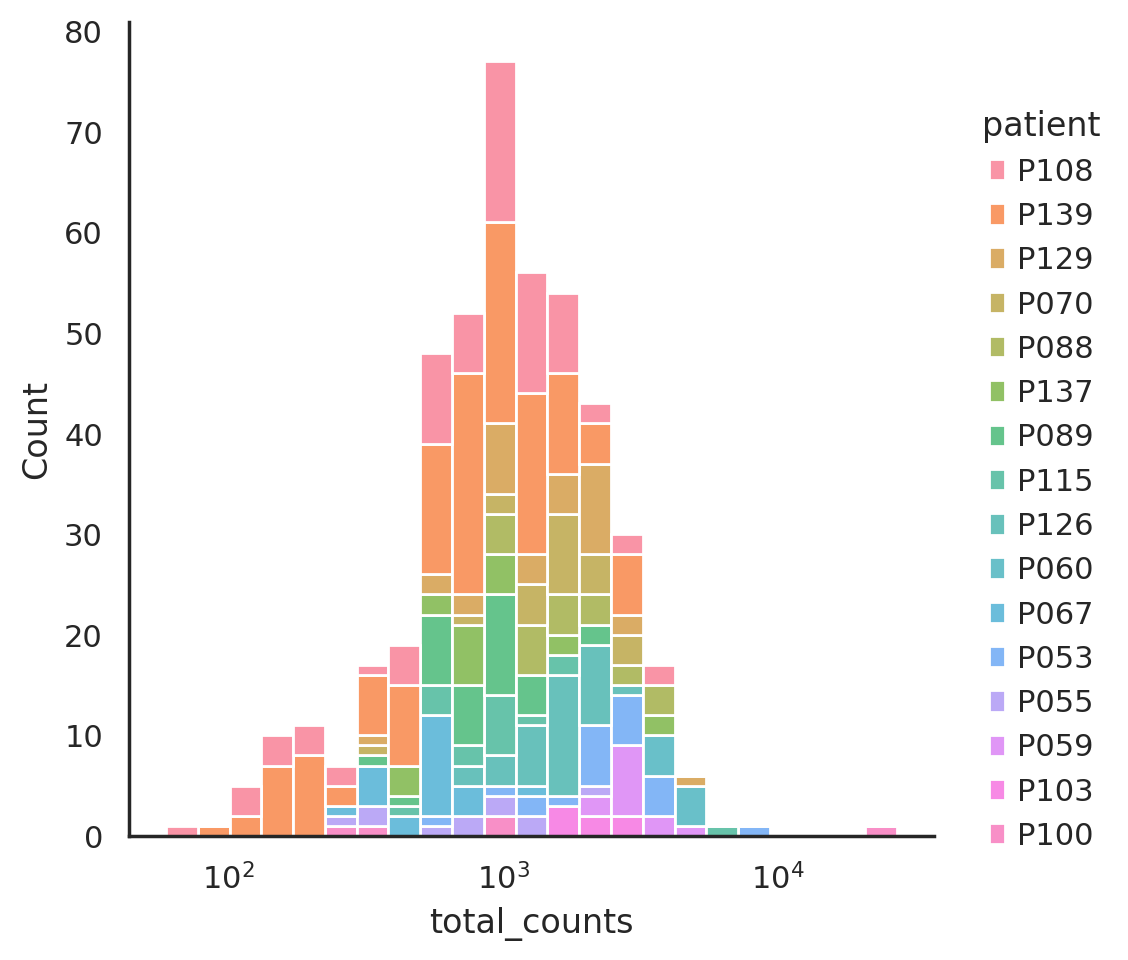

In [197]:
sns.displot(
    mod_cite.obs.sample(frac=0.01).query("total_counts>10"),
    x="total_counts",
    log_scale=True,
    hue="patient",
    multiple="stack",
)

In [198]:
mod_cite = mod_cite[total_counts_max_mask, :].copy()

In [199]:
sc.pp.filter_genes(mod_cite, min_cells=10)
mod_cite.shape

(72416, 206)

<AxesSubplot: xlabel='sample', ylabel='total_counts'>

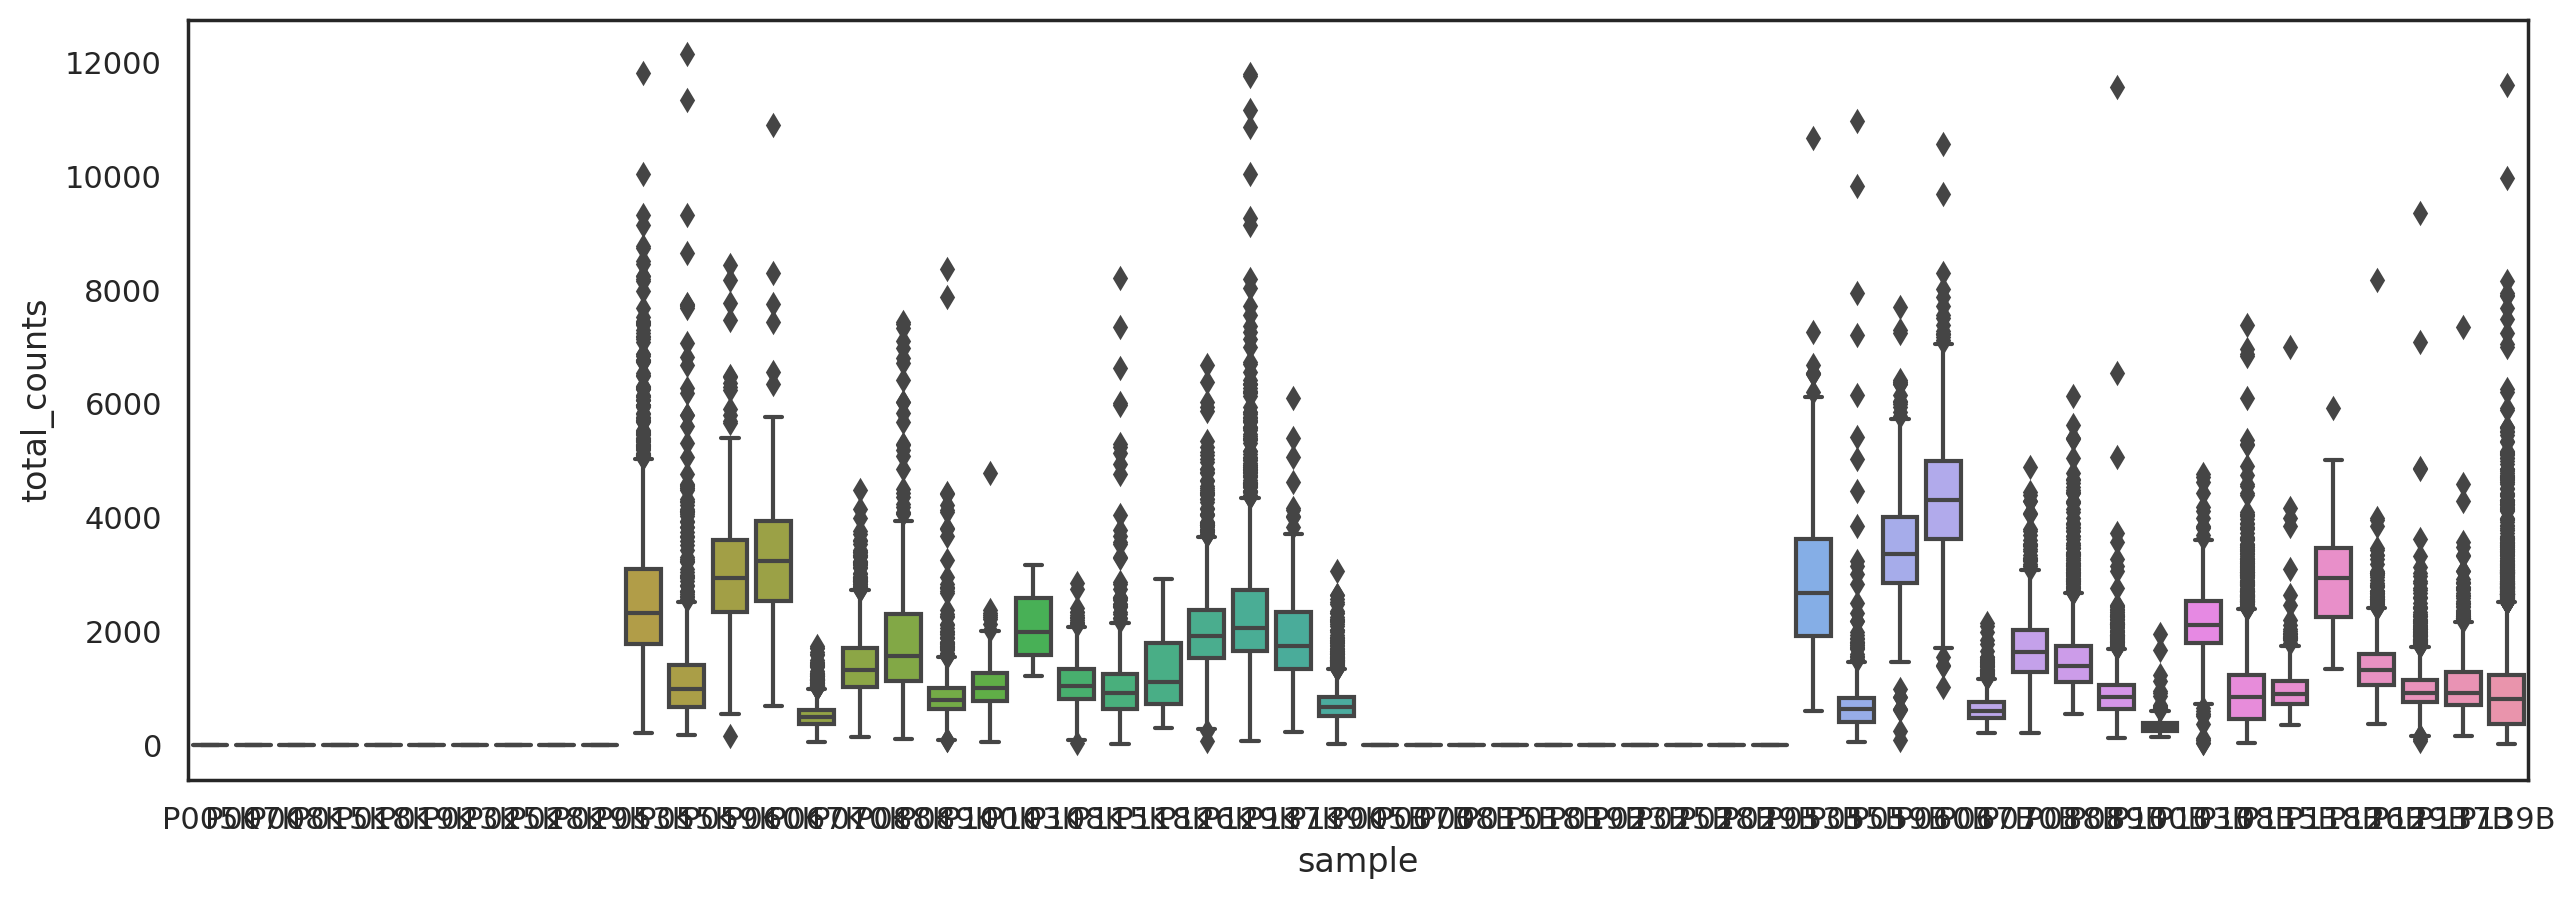

In [200]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(y=mod_cite.obs.total_counts, x=mod_cite.obs["sample"], ax=ax)

<AxesSubplot: xlabel='patient', ylabel='n_genes_by_counts'>

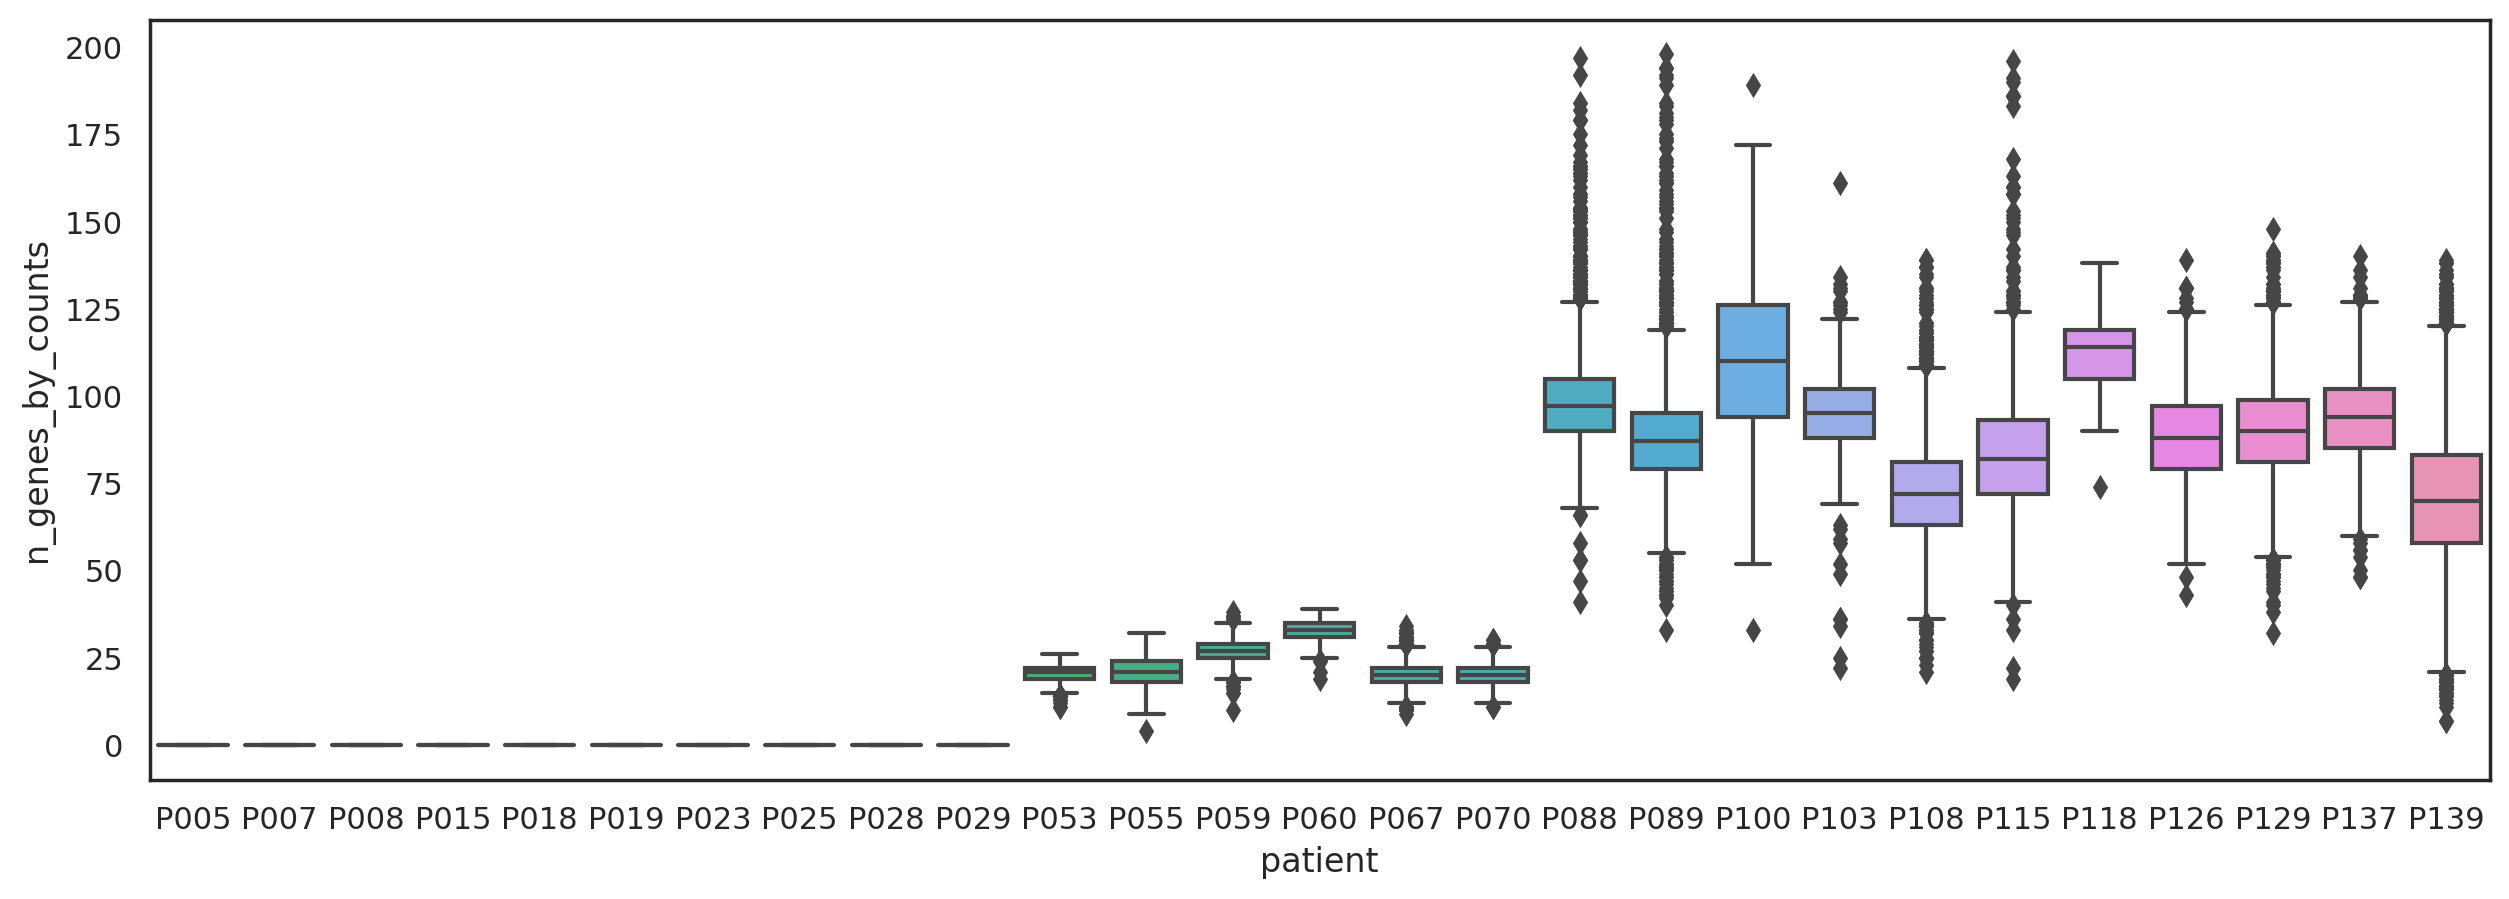

In [201]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(y=mod_cite.obs.n_genes_by_counts, x=mod_cite.obs["patient"], ax=ax)

In [202]:
protein_clr(mod_cite)

In [203]:
mod_cite

AnnData object with n_obs × n_vars = 72416 × 206
    obs: 'patient', 'sample', 'tissue', 'cell_type_yu', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'counts', 'clr'

## Harmonize CITE and RNA

In [206]:
n_cells_cite = mod_cite.shape[0]
n_cells_rna = mod_rna.shape[0]
print(f"Number of cells in RNA: {n_cells_rna}")
print(f"Number of cells in CITE: {n_cells_cite}")

Number of cells in RNA: 72453
Number of cells in CITE: 72416


In [207]:
shared_obs_names = [name for name in mod_rna.obs_names if name in mod_cite.obs_names]
mod_rna = mod_rna[shared_obs_names, :].copy()
mod_cite = mod_cite[shared_obs_names, :].copy()

## Save everything

In [208]:
mudata = md.MuData(
    {
        "rna": mod_rna,
        "cite": mod_cite,
    }
)

In [209]:
mudata.write_h5mu("data/anca/exploratory/ANCA_27PK27PB_T_processed.h5mu")

... storing 'patient' as categorical
... storing 'sample' as categorical
... storing 'tissue' as categorical
